In [1]:
# 구글 코랩에서 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import tensorflow as tf

female_model = tf.keras.applications.InceptionV3(weights=None, include_top=True, input_shape=(224,224,1), classes=1, classifier_activation=None)

In [11]:
female_model.compile(loss='mae', optimizer='adam')

In [2]:
import pandas as pd

csv_train=pd.read_csv('/content/drive/Shareddrives/growthPrediction/machineLearning/boneage-training-dataset.csv')
csv_train.head()

,id,boneage,male
0,1377,180,False
1,1378,18,False
2,1379,94,False
3,1380,156,True
4,1381,82,False


In [3]:
for i in range(len(csv_train['id'])):
  csv_train.loc[i,"id"] = f"{csv_train['id'][i]}.png"

csv_train.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,18,False
2,1379.png,94,False
3,1380.png,156,True
4,1381.png,82,False


In [4]:
female_df = csv_train.loc [csv_train.male != True]
female_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,18,False
2,1379.png,94,False
4,1381.png,82,False
10,1388.png,126,False


In [5]:
len(female_df)

5489

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # random으로 validation 뽑음

train_generator = datagen.flow_from_dataframe(female_df, directory='/content/drive/Shareddrives/growthPrediction/machineLearning/dataset/boneage-training-dataset/boneage-training-dataset', 
                                              x_col='id', y_col='boneage',
                                              target_size=(224,224), color_mode='grayscale',
                                              class_mode='raw', subset='training')
valid_generator = datagen.flow_from_dataframe(female_df, directory='/content/drive/Shareddrives/growthPrediction/machineLearning/dataset/boneage-training-dataset/boneage-training-dataset', 
                                              x_col='id', y_col='boneage',
                                              target_size=(224,224), color_mode='grayscale', 
                                              class_mode='raw', subset='validation', shuffle=False)


Found 4392 validated image filenames.
Found 1097 validated image filenames.


In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True,
                                                filepath="/content/drive/Shareddrives/growthPrediction/machineLearning/model_f")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = female_model.fit_generator(train_generator, validation_data=valid_generator, epochs=100, callbacks=[checkpoint, early_stopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
  7/138 [>.............................] - ETA: 23:00 - loss: 108.6348

KeyboardInterrupt: ignored

In [ ]:
# 학습 과정에서의 loss와 val_loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [7]:
csv_test=pd.read_csv('/content/drive/Shareddrives/growthPrediction/machineLearning/boneage-test-dataset.csv')
csv_test.head()

for i in range(len(csv_test['id'])) :
  csv_test.loc[i,"id"] = f"{csv_test['id'][i]}.png"

test_df = csv_test.loc[csv_test.male == False]
test_df.head()
len(test_df)

testDatagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_generator = testDatagen.flow_from_dataframe(test_df, directory='/content/drive/Shareddrives/growthPrediction/machineLearning/dataset/boneage-test-dataset', 
                                              x_col='id', y_col='boneage',
                                              target_size=(224,224), color_mode='grayscale',
                                              class_mode='raw')

Found 289 validated image filenames.


In [12]:
# 예측값과 정답값을 비교
load_model = tf.keras.models.load_model("/content/drive/Shareddrives/growthPrediction/machineLearning/check_point_f")

import numpy as np

def changeYear(ARR) :
  NewARR = []
  for num in ARR :  
    year = num / 12
    remainder = year % 1
    
    if remainder <= 0.25 :
      remainder = 0
      NewARR.append(int(year) + remainder)
    elif remainder <= 0.75 :
      remainder = 0.5
      NewARR.append(int(year) + remainder)
    else :
      remainder = 1
      NewARR.append(int(year) + remainder)
  return NewARR

predict = load_model.predict_generator(test_generator).flatten()
predict_year = changeYear(predict)
answer_year = changeYear(test_generator.labels)

mae_month = [abs(predict[i] - test_generator.labels[i]) for i in range(len(predict))]
mae_year = [abs(predict_year[i] - answer_year[i]) for i in range(len(predict_year))]

compare = pd.DataFrame({"id" : test_generator.filenames,
                        "예측(개월)" : predict,
                        "정답(개월)" : test_generator.labels,
                        "예측(년)" : predict_year,
                        "정답(년)" : answer_year,
                        "mae(년)" : mae_year})

total_mae_month = np.mean(mae_month)
total_mae_year = np.mean(mae_year)

compare.head(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


,id,예측(개월),정답(개월),예측(년),정답(년),mae(년)
0,14936.png,128.006622,120,10.5,10.0,0.5
1,14938.png,61.573132,162,5.0,13.5,8.5
2,14940.png,142.142181,120,12.0,10.0,2.0
3,14942.png,62.954567,126,5.0,10.5,5.5
4,14945.png,134.455917,156,11.0,13.0,2.0
...,...,...,...,...,...,...
95,15162.png,109.428223,50,9.0,4.0,5.0
96,15163.png,138.361984,106,11.5,9.0,2.5
97,15164.png,151.329681,60,12.5,5.0,7.5
98,15165.png,123.883789,132,10.5,11.0,0.5


In [13]:
print(total_mae_month, total_mae_year)

39.39163578917823 3.2785467128027683


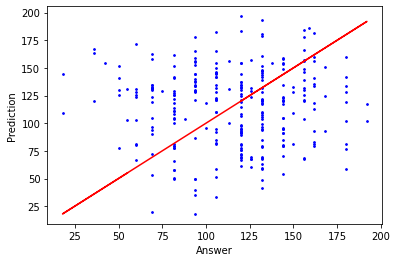

In [ ]:
# 최종 결과값과 예측값 비교 시각화
import matplotlib.pyplot as plt

plt.scatter(test_generator.labels, predict, color='b' , s=3)
plt.plot(test_generator.labels, test_generator.labels, 'r')
plt.xlabel("Answer")
plt.ylabel("Prediction")
plt.show()